<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Valid_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !gdown https://drive.google.com/uc?id=1kl1NQvbcre7ktBmaxvdZ5fN_EmQQicBL

In [ ]:
# !gdown https://drive.google.com/uc?id=1gJD_PD9mVfW10neMtQFg2L-t4pgoz07O

In [ ]:
# !unzip /content/mulitmodal_joint_224x224.zip

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Loading Validation Dataset and Preprocessing

In [ ]:
save_dir = "/content/Model/Models-Train-02/"
load_path = os.path.join(save_dir, '17_model.pth')

resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 101)               #  change the output classes to number of classes for your model

resnet.load_state_dict(torch.load(load_path))
# resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
resnet.eval()
resnet.to(device)

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, val_transform):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir)
        self.classes = self.dataset.classes
        self.val_transform = val_transform

        self.selected_indices = []
        for class_idx in range(len(self.classes)):
            indices = [idx for idx, (_, label) in enumerate(self.dataset.samples) if label == class_idx]
            indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
            indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

            self.selected_indices.extend(indices_4)
            # self.selected_indices.extend(indices_3)
        print("Selected Indices:", len(self.selected_indices))
        # for idx in self.selected_indices:
          # print(self.dataset.samples[idx][0])

    def __getitem__(self, index):
        # print("Entered get_item")
        img, label = self.dataset[self.selected_indices[index]]
        filename = self.dataset.samples[self.selected_indices[index]][0]
        image_3 = None
        image_4 = None
        if filename.endswith("_4.png"):
                image_4 = img
                image_4_path = filename
                # print("image_4_path: ", str(filename))
                image_3_path = filename.replace('_4.png', '_3.png')
                # print("image_3_path: ", str(image_3_path))
                image_3 = self._load_image(image_3_path)
        else:
                image_3 = img
                image_3_path = filename
                # print("image_3_path: ", str(filename))
                image_4_path = filename.replace('_3.png', '_4.png')
                # print("image_4_path: ", str(image_4_path))
                image_4 = self._load_image(image_4_path)

        # print("Exit get_item")
        return image_3, image_4, label, image_3_path, image_4_path

    def _load_image(self, path):
        image = Image.open(path)
        return image

    def __len__(self):
        return len(self.selected_indices)

In [6]:
valPath = "/content/Dataset(s)/joint-food-101/test"
val_dataset = ValidationDataset(valPath,val_transform)

Selected Indices: 22716


In [7]:
def custom_collate(batch):
    to_tensor = transforms.ToTensor()
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    images_3 = [val_transform(item[0]) for item in batch]
    images_4 = [val_transform(item[1]) for item in batch]
    labels = [torch.tensor(item[2]) for item in batch]

    images_3 = torch.stack(images_3)
    images_4 = torch.stack(images_4)

    # Print the filenames in each list
    # print("Filenames in images_3 list:")
    # for item in batch:
    #     if item[0] is not None:
    #         print(item[3])

    # print("Filenames in images_4 list:")
    # for item in batch:
    #     if item[1] is not None:
    #         print(item[4])

    return images_3, images_4, labels


In [8]:
batch_size = 16
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

In [9]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 22716
Number of classes: 101


# Validation

In [10]:
num_batches = len(validation_data_loader)
num_batches_with_logits_3 = int(num_batches * 0.3)  # __% of batches that you want to include (30 for now)
print("Total Batches: ", num_batches)
print("Missing Modaility Batches: ", num_batches_with_logits_3)

Total Batches:  1420
Missing Modaility Batches:  426


In [11]:
resnet.eval()

predicted_labels = []
true_labels = []

batch_idx = 0
for images_3, images_4, labels in validation_data_loader:

    images_4 = images_4.to(device)
    logits_4 = resnet(images_4)

    if batch_idx < num_batches_with_logits_3:
        images_3 = images_3.to(device)
        logits_3 = resnet(images_3)
    else:
        logits_3 = torch.zeros_like(logits_4)

    probabilities_3 = torch.softmax(logits_3, dim=1)
    probabilities_4 = torch.softmax(logits_4, dim=1)

    avg_probabilities_batch = (probabilities_3 + probabilities_4) / 2

    predicted_labels.extend(avg_probabilities_batch.cpu().tolist())
    true_labels.extend(labels)
    batch_idx += 1

print(batch_idx)

1420


In [12]:
predicted_classes = torch.argmax(torch.tensor(predicted_labels), dim=1)
actual_labels = torch.tensor(true_labels)

In [13]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7071227328755062
Precision: 0.7093786749064019
Recall: 0.7071227328755062
F1-score: 0.7004136005147582


In [14]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       234
           1       0.77      0.95      0.85       221
           2       0.83      0.95      0.88       226
           3       0.78      0.79      0.79       222
           4       0.62      0.72      0.67       225
           5       0.85      0.90      0.87       224
           6       0.74      0.92      0.82       224
           7       0.82      0.88      0.85       225
           8       0.71      0.97      0.82       226
           9       0.79      0.86      0.83       214
          10       0.65      0.97      0.78       231
          11       0.80      0.90      0.85       227
          12       0.81      0.93      0.86       230
          13       0.82      0.93      0.87       220
          14       0.85      0.84      0.84       231
          15       0.67      0.92      0.78       227
          16       0.76      0.75      0.76       224
          17       0.69    

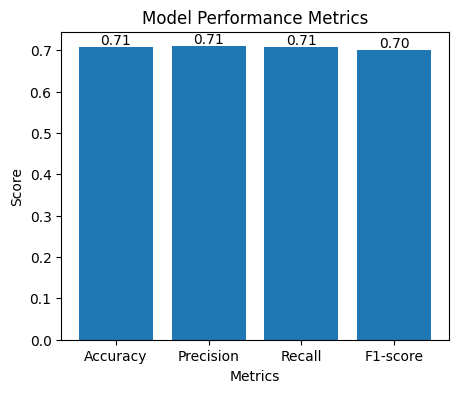

In [15]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

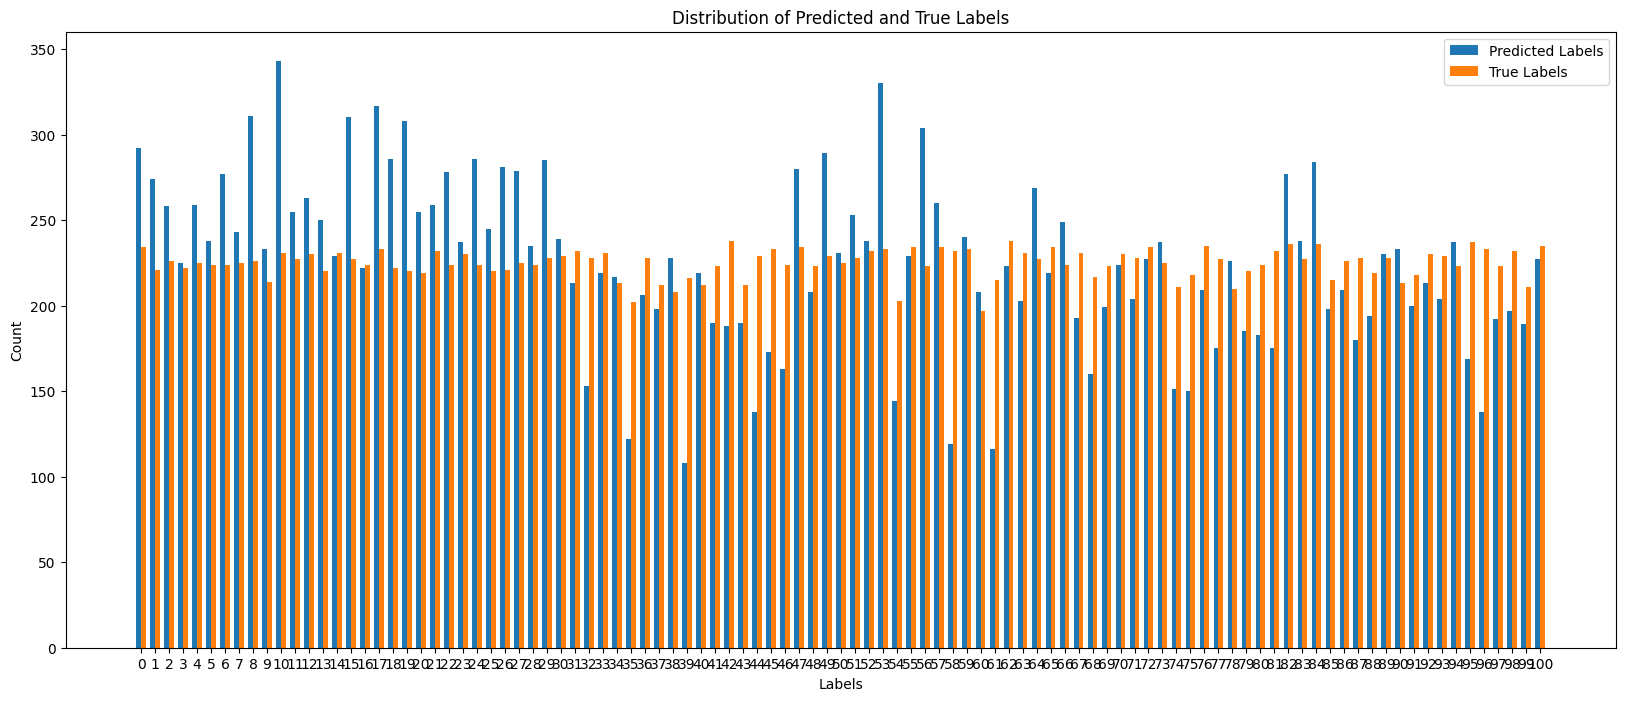

In [16]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()